# Basic usage of PHYSBO

## Introduction

In this tutorial, the problem of finding a stable interface structure for Cu is solved as an example. The values that have already been evaluated are used, although the evaluation of the objective function, i.e., the structural relaxation calculation, actually takes on the order of several hours per calculation. For more information on the problem setup, please refer to the following references

- S. Kiyohara, H. Oda, K. Tsuda and T. Mizoguchi, “Acceleration of stable interface structure searching using a kriging approach”, Jpn. J. Appl. Phys. 55, 045502 (2016).

---

Let's try each step using the sample data.

First, we will import PHYSBO.

In [1]:
import physbo

## Preparation of search candidate data

First, load the data.

In [2]:
import numpy as np

def load_data():
    A =  np.asarray(np.loadtxt('data/s5-210.csv',skiprows=1, delimiter=',') )
    X = A[:,0:3]
    t  = -A[:,3]
    return X, t

In [3]:
X, t = load_data()

In the following, N is defined as the number of search candidates and d is defined as the dimensionality of the input parameters.

X is an N x d matrix, where each row represents a parameter set (a d-dimensional vector) for each candidate.  
t is a vector of N dimensions, corresponding to the negative energy of each candidate (the value of the objective function to be optimized).
Normally, when we perform Bayesian optimization, we start with only X given and t does not exist. Therefore, in actual use, the value of t can only be obtained by receiving a candidate Bayesian optimization proposal and evaluating it with a simulator. Since this is a tutorial, we will skip the calculations and give t in advance.

**PHYSBO assumes that the direction of optimization is "maximization".**  

Therefore, the original problem setting is "energy minimization", but when optimizing with PHYSBO, the objective function value is multiplied by a negative value and treated as a "negative energy maximization" problem.

In [4]:
X

array([[0. , 1. , 0. ],
       [0. , 1. , 0.1],
       [0. , 1. , 0.2],
       ...,
       [8. , 1.5, 3.4],
       [8. , 1.5, 3.5],
       [8. , 1.5, 3.6]])

In [5]:
t

array([-1.01301176, -1.01487066, -1.02044168, ..., -1.11680203,
       -2.48876352, -2.4971452 ])

To scale the search parameters, standardize each column of X so that the mean is 0 and the variance is 1, respectively.

In [6]:
X = physbo.misc.centering( X )

In [7]:
X

array([[-1.71079785, -1.46385011, -1.68585446],
       [-1.71079785, -1.46385011, -1.59219588],
       [-1.71079785, -1.46385011, -1.4985373 ],
       ...,
       [ 1.71079785,  1.46385011,  1.4985373 ],
       [ 1.71079785,  1.46385011,  1.59219588],
       [ 1.71079785,  1.46385011,  1.68585446]])

## Definition of simulator

Define the simulator class called in PHYSBO.  
The return value of the `__call__` method is the value of the objective function when action is given.  
action is the ID of the search candidate (0, 1, ..., N-1). , N-1).

In this tutorial, we have defined a simulator that only returns the already computed value of t when action is given.  
Please customize the simulator class if you want to apply it to other problems.

In [8]:
class Simulator:
    def __init__( self ):
        _, self.t = load_data()
    
    def __call__( self, action ):
        return self.t[action]

## Performing optimization

### Setting policy

First, set the optimization `policy`.  

Next, set `test_X` to the matrix of search candidates (`numpy.array`).

In [9]:
# set policy 
policy = physbo.search.discrete.Policy(test_X=X)

# set seed
policy.set_seed(0)

When `policy` is set, no optimization is done yet.
Execute the following methods on `policy` to optimize it.

- `random_search`.  
- `bayes_search`.

If you specify the `simulator` and the number of search steps in these methods, the following loop will be executed for the number of search steps.

i) Select the next parameter to be executed from the candidate parameters.

ii) Execute `simulator` with the selected parameters.

The default number of parameter returned by i) is one, but it is possible to return multiple parameters in one step.
See the section "Searching for multiple candidates at once" for details.  

Also, instead of running the above loop inside PHYSBO, it is possible to control i) and ii) separately from the outside. In other words, it is possible to propose the next parameter to be executed from PHYSBO, evaluate its objective function value in some way outside PHYBO (e.g., by experiment rather than numerical calculation), propose it in some way outside PHYSBO, and register the evaluated value in PHYSBO. For more details, please refer to the "Running Interactively" section of the tutorial.

### Random Search

First of all, let's perform a random search.

Since Bayesian optimization requires at least two objective function values to be obtained (the initial number of data required depends on the problem to be optimized and the dimension d of the parameters), we will first perform a random search.   

**argument**.  

- `max_num_probes`: Number of search steps.  
- `simulator`: The simulator of the objective function (an object of class simulator). 

In [10]:
res = policy.random_search(max_num_probes=20, simulator=Simulator())

When executed, the objective function value and its action ID for each step, and the best value up to now and its action ID will be printed as follows.

````
0020-th step: f(x) = -1.048733 (action=1022)
   current best f(x) = -0.963795 (best action=5734) 
````


### Bayesian Optimization

Next, we run the Bayesian optimization as follows.

**argument**.  

- `max_num_probes`: Number of search steps.  
- `simulator`: The simulator of the objective function (an object of class simulator).  
- `score`: The type of acquisition function. You can specify one of the following
    - TS (Thompson Sampling)  
    - EI (Expected Improvement)  
    - PI (Probability of Improvement)  
- `interval`:  
The hyperparameters are trained at the specified interval.  
If a negative value is specified, no hyperparameter will be learned.  
0 means that hyperparameter learning will be performed only in the first step.  
- `num_rand_basis`: Number of basis functions. 0 means that a normal Gaussian process without Bayesian linear model will be used.  

In [11]:
res = policy.bayes_search(max_num_probes=80, simulator=Simulator(), score='TS', 
                                                  interval=20, num_rand_basis=5000)

## Checking the results

The search result ``res`` is returned as an object of the ``history`` class (`physbo.search.discrete.results.history`).  
The following is a reference to the search results.

- `res.fx` : The history of evaluated values of simulator (objective function).
- `res.chosen_actions`: The history of action IDs (parameters) when the simulator was evaluated.  
- `fbest, best_action= res.export_all_sequence_best_fx()`: The history of best values and their action IDs (parameters) for all timings when the simulator was evaluated.
- `res.total_num_search`: Total number of simulator evaluations.

Let's plot the objective function value and the best value at each step.  
`res.fx` and `best_fx` should range up to `res.total_num_search`, respectively.

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

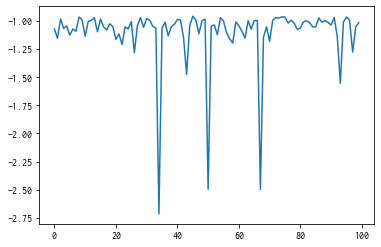

In [13]:
plt.plot(res.fx[0:res.total_num_search])

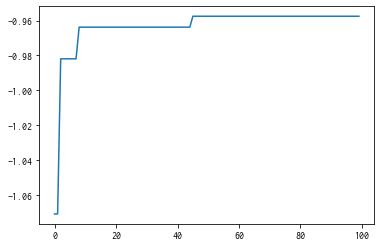

In [14]:
best_fx, best_action = res.export_all_sequence_best_fx()
plt.plot(best_fx)

## Serializing the results

The search results can be saved to an external file using the `save` method.

In [15]:
res.save('search_result.npz')

In [16]:
del res

Load the saved result file as follows:

In [17]:
res = physbo.search.discrete.results.history()
res.load('search_result.npz')